# DAND Project: Data Wrangling
### Author: Rupam Banerjee

## Gather

In [1]:
# import packages
import requests
import os
import pandas as pd
import tweepy
import json
import numpy as np
import re

### Fetching information for twitter archive

In [2]:
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Fetching information for image prediction

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
folder_name = url.split('/')[-1]
if not os.path.exists(folder_name):
    r = requests.get(url)
    with open(folder_name, mode='wb') as file:
        file.write(r.content)
        
df_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
df_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Fetching information for Tweet.API

#### Tweeter Credentials for authentication

In [4]:
consumer_key = 'vBnroGRQywHJWT0KQQcOWxspt'
consumer_secret = 'LKLfqLVRKVGXbBQBH3IMga883BrE3cLBlImtpvZPx6OvOMy1lN'
access_token = '2264850980-MkGY0WEOph2YthFp86lCD7y9CvZhzgM3FW6a8Le'
access_secret = 'QdvWcpdCxpo9urCmwUSaGkJ8dOKYuB9gZ0GvWyuHV5yo7'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#### Fetching info. form twitter API

In [5]:
if not os.path.exists('tweet_json.txt'):
    df_additional_tweet = {}
    df_additional_tweet['tweets'] = []
    # get tweet information for each tweet id
    for indx, tweet_id in enumerate(df_archive.tweet_id):
        # see where we're in the process
        # because it can take a while
        if (indx+1)%50 == 0:
            print('{} tweets have been viewed.'.format(indx+1))
        # Some tweets can't be found and throw an error
        try:
            tweet = api.get_status(id = tweet_id)
            df_additional_tweet['tweets'].append({
                "tweet_id": tweet_id,
                "retweet_count": tweet.retweet_count,
                "favourite_count": tweet.favorite_count,
            })
        # record the tweets that can't be found
        except:
            print('{} tweet id doesn\'t exist anymore'.format(tweet_id))

    # save tweets as json object into a text file
    with open('tweet_json.txt', 'w') as outfile:
        json.dump(df_additional_tweet, outfile)

In [6]:
with open('tweet_json.txt') as json_f:
    df_additional_tweet = pd.DataFrame(columns = ['tweet_id','favorites','retweets'])
    
    for info in json_f:
        tweets = json.loads(info)
        data = {'tweet_id': tweets['id'],'favorites': tweets['favorite_count'],
                                      'retweets': tweets['retweet_count']}
        ser = pd.Series(data)
        df_additional_tweet = df_additional_tweet.append(data,ignore_index=True)
df_additional_tweet.head()

,tweet_id,favorites,retweets
0,892420643555336193,37182,7953
1,892177421306343426,31977,5906
2,891815181378084864,24079,3904
3,891689557279858688,40492,8099
4,891327558926688256,38725,8790


## Access

In [7]:
df_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1690,681339448655802368,NaN,NaN,2015-12-28 05:02:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Asher. He's not wearing a seatbelt or ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681339448...,9,10,Asher,None,None,None,None
1815,676613908052996102,NaN,NaN,2015-12-15 04:05:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is the saddest/sweetest/best picture I've...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676613908...,12,10,the,None,None,None,None
1236,712438159032893441,NaN,NaN,2016-03-23 00:37:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kane. He's a semi-submerged Haitian Hu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/712438159...,11,10,Kane,None,None,None,None
2083,670811965569282048,NaN,NaN,2015-11-29 03:50:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Maggie. She enjoys her stick in the yard....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670811965...,10,10,Maggie,None,None,None,None
2347,666057090499244032,NaN,NaN,2015-11-16 00:55:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",My oh my. This is a rare blond Canadian terrie...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666057090...,9,10,a,None,None,None,None


In [8]:

df_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1275,750056684286914561,https://pbs.twimg.com/media/Cmfx2oNW8AAGg4H.jpg,1,Saluki,0.484428,True,borzoi,0.263550,True,Labrador_retriever,0.077004,True
38,666644823164719104,https://pbs.twimg.com/media/CUBl6IwVAAA9_zT.jpg,1,Ibizan_hound,0.044333,True,Pembroke,0.043209,True,West_Highland_white_terrier,0.038906,True
404,673705679337693185,https://pbs.twimg.com/media/CVl7u00WcAAufzR.jpg,1,Shih-Tzu,0.165383,True,Lhasa,0.116977,True,Yorkshire_terrier,0.063899,True
1602,800018252395122689,https://pbs.twimg.com/ext_tw_video_thumb/80001...,1,vacuum,0.289485,False,punching_bag,0.243297,False,barbell,0.143630,False
740,687312378585812992,https://pbs.twimg.com/media/CYnS9VWW8AAeR8m.jpg,1,seat_belt,0.703561,False,Great_Dane,0.139909,True,Weimaraner,0.021112,True


In [9]:
df_additional_tweet.sample(5)

,tweet_id,favorites,retweets
1990,672231046314901505,1813,996
203,851861385021730816,0,20
1167,718246886998687744,1972,510
783,772152991789019136,3944,1176
2029,671486386088865792,575,196


In [10]:
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [12]:
df_additional_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 3 columns):
tweet_id     2333 non-null object
favorites    2333 non-null object
retweets     2333 non-null object
dtypes: object(3)
memory usage: 54.8+ KB


In [13]:
df_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [14]:
df_predictions.p1_conf.sort_values(ascending=True)[0:10]

38      0.044333
136     0.055379
1093    0.059033
1370    0.063152
246     0.070076
250     0.071124
145     0.071536
680     0.072885
701     0.081101
1831    0.082489
Name: p1_conf, dtype: float64

In [15]:
df_additional_tweet.describe()

,tweet_id,favorites,retweets
count,2333,2333,2333
unique,2333,1983,1718
top,667495797102141441,0,55
freq,1,165,6


In [16]:
df_additional_tweet.duplicated().sum()

0

In [17]:
df_archive.duplicated().sum()

0

In [18]:
df_predictions.duplicated().sum()

0

In [19]:
df_archive.rating_numerator.sort_values(ascending=False)[:30]

979     1776
313      960
189      666
188      420
2074     420
1120     204
290      182
902      165
1779     144
1634     143
1635     121
1228      99
1843      88
433       84
1254      80
695       75
340       75
1351      60
1202      50
1274      45
1433      44
763       27
1712      26
516       24
1663      20
55        17
285       15
291       15
83        14
866       14
Name: rating_numerator, dtype: int64

In [20]:
df_archive.query('rating_denominator != 10')['rating_denominator']

313       0
342      15
433      70
516       7
784      11
902     150
1068     11
1120    170
1165     20
1202     50
1228     90
1254     80
1274     50
1351     50
1433     40
1598     20
1634    130
1635    110
1662     11
1663     16
1779    120
1843     80
2335      2
Name: rating_denominator, dtype: int64

### Quality

#### archive table
- predictions table
- has smaller number of tweets than the other tables
- tweet_id is an integer
- additional_tweet_info table
- has smaller number of tweets than the archive table
- tweet_id is an integer
- the source is a link instead of just utility used to make the tweet
- 'name', 'doggo', 'floofer', 'pupper', and 'puppo' columns have string values of "None" instead of NaN
- few of the names starts with 'a', 't***' and so on
- timestamp column value is a string object
- expanded_urls column has missing values
- tweet_id is an integer
- some tweets are replies to other tweets ('in_reply_to_status_id', 'in_reply_to_user_id')
- some tweets are retweets ('retweeted_status_id', 'retweeted_status_user_id')
- some rating numerator values are really high (1776, 960, 666, 420 ...)
- some rating denominator values range from 0 to 170

#### Tidiness
- columns 'name', 'doggo', 'floofer', 'pupper', and 'puppo' are all one variable
- df_archive and df_additional_tweet are part of one observational unit

### Clean

In [21]:
tweets_clean = df_archive.copy()
predictions_clean = df_predictions.copy()
tweets_additional_info_clean = df_additional_tweet.copy()

<b><i>tweets archive</i>: some tweets are replies to other tweets ('in_reply_to_status_id', 'in_reply_to_user_id').</b>

#### Define
- Remove rows where tweets are replies.

#### Code

In [22]:
tweets_clean = tweets_clean[tweets_clean.in_reply_to_status_id.isna()]
tweets_clean = tweets_clean[tweets_clean.in_reply_to_user_id.isna()]

#### Test

In [23]:
print(tweets_clean.in_reply_to_status_id.notna().sum())
print(tweets_clean.in_reply_to_user_id.notna().sum())

0
0


#### Define
- Drop 'in_reply_to_status_id', 'in_reply_to_user_id' columns.

#### Code

In [24]:
tweets_clean.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id'], inplace=True)

#### Test

In [25]:
tweets_clean.head()

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Define
- Remove entries that are retweets.

#### Code

In [26]:
tweets_clean = tweets_clean[tweets_clean.retweeted_status_id.isna()]
tweets_clean = tweets_clean[tweets_clean.retweeted_status_user_id.isna()]

#### Test

In [27]:
print(tweets_clean.retweeted_status_id.notna().sum())
print(tweets_clean.retweeted_status_user_id.notna().sum())

0
0


#### Define
- Drop 'retweeted_status_id', 'retweeted_status_user_id', and 'retweeted_status_timestamp' columns.

#### Code

In [28]:
tweets_clean.drop(columns=['retweeted_status_id', 'retweeted_status_user_id', 
                           'retweeted_status_timestamp'],
                  inplace=True)

#### Test

In [29]:
tweets_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Define
- Extract source from the links using regular experessions.

#### Code

In [30]:
tweets_clean.source = tweets_clean.source.apply(lambda x: x.split('/')[-2]).str.extract('>(\D+)<')

#### Test

In [31]:
tweets_clean.source.sample(5)

1848    Twitter for iPhone
2102    Twitter for iPhone
235     Twitter for iPhone
734     Twitter for iPhone
1745    Twitter for iPhone
Name: source, dtype: object

#### Define
- Replace 'None' string values with NaN. As 'name', 'doggo', 'floofer', 'pupper', and 'puppo' columns have string values of "None" instead of NaN

#### Code

In [32]:
columns = ['name', 'doggo', 'floofer', 'pupper', 'puppo']
for col in columns:
    tweets_clean[col] = tweets_clean[col].apply(lambda x: np.NaN if x == 'None' else x)

#### Test

In [33]:
tweets_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1928,674045139690631169,2015-12-08 01:57:39 +0000,Twitter for iPhone,Herd of wild dogs here. Not sure what they're ...,https://twitter.com/dog_rates/status/674045139...,3,10,NaN,NaN,NaN,NaN,NaN
2321,666435652385423360,2015-11-17 02:00:15 +0000,Twitter for iPhone,"""Can you behave? You're ruining my wedding day...",https://twitter.com/dog_rates/status/666435652...,10,10,NaN,NaN,NaN,NaN,NaN
37,885167619883638784,2017-07-12 16:03:00 +0000,Twitter for iPhone,Here we have a corgi undercover as a malamute....,https://twitter.com/dog_rates/status/885167619...,13,10,NaN,NaN,NaN,NaN,NaN
2253,667793409583771648,2015-11-20 19:55:30 +0000,Twitter for iPhone,Dogs only please. Small cows and other non can...,https://twitter.com/dog_rates/status/667793409...,8,10,NaN,NaN,NaN,NaN,NaN
1595,686358356425093120,2016-01-11 01:25:58 +0000,Twitter for iPhone,Heartwarming scene here. Son reuniting w fathe...,https://twitter.com/dog_rates/status/686358356...,10,10,NaN,NaN,NaN,NaN,NaN


#### Define
- Change timestime column to DateTime.

#### Code

In [34]:
tweets_clean.timestamp = pd.to_datetime(tweets_clean.timestamp)

#### Test

In [35]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns, UTC]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  1494 non-null object
doggo                 83 non-null object
floofer               10 non-null object
pupper                230 non-null object
puppo                 24 non-null object
dtypes: datetime64[ns, UTC](1), int64(3), object(8)
memory usage: 213.0+ KB


#### Define
- Remove this column because it doesn't provide any new information since we can identify tweets using tweet id.

#### Code

In [36]:
tweets_clean.drop(columns=['expanded_urls'], inplace=True)

#### Test

In [37]:
tweets_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,NaN,NaN,NaN


#### Define
- Change tweet_id data type to string.

#### Code

In [38]:
tweets_clean.tweet_id = tweets_clean.tweet_id.astype(str)
predictions_clean.tweet_id = predictions_clean.tweet_id.astype(str)
tweets_additional_info_clean.tweet_id = tweets_additional_info_clean.tweet_id.astype(str)

#### Test

In [39]:
print(type(tweets_clean.tweet_id[0]))
print(type(predictions_clean.tweet_id[0]))
print(type(tweets_additional_info_clean.tweet_id[0]))

<class 'str'>
<class 'str'>
<class 'str'>


#### Define
- Leave tweets that are present in all three tables and drop the rest.

#### Code

In [40]:
common = tweets_clean.merge(predictions_clean, on=['tweet_id', 'tweet_id'])
common = common.merge(tweets_additional_info_clean, on=['tweet_id', 'tweet_id'])
tweets_clean = tweets_clean[tweets_clean.tweet_id.isin(common.tweet_id)]
predictions_clean = predictions_clean[predictions_clean.tweet_id.isin(common.tweet_id)]
tweets_additional_info_clean = tweets_additional_info_clean[tweets_additional_info_clean.tweet_id.isin(common.tweet_id)]

#### Test

In [41]:
print(tweets_clean.shape)
print(predictions_clean.shape)
print(tweets_clean.shape)

(1964, 11)
(1964, 12)
(1964, 11)


#### Tidiness
- tweets archive: columns 'doggo', 'floofer', 'pupper', and 'puppo' are all one variable.

#### Define
- Concatenate all four columns.

#### Code

In [42]:
tweets_clean['dog_rank'] = tweets_clean[['doggo', 'floofer', 'pupper', 'puppo']].astype(str).sum(1)

In [43]:
tweets_clean['dog_rank'] = tweets_clean['dog_rank'].apply(lambda x: x.replace('nan', ''))
tweets_clean['dog_rank'] = tweets_clean['dog_rank'].apply(lambda x: np.NaN if x == '' else x)
tweets_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

#### Test

In [44]:
tweets_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_rank
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN


#### Define
- Merge two tables on tweet id.

#### Code

In [45]:
tweets_clean = tweets_clean.merge(tweets_additional_info_clean, left_on='tweet_id', right_on='tweet_id')

#### Test

In [46]:
tweets_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_rank,favorites,retweets
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,NaN,37182,7953
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13,10,Tilly,NaN,31977,5906
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,NaN,24079,3904
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,13,10,Darla,NaN,40492,8099
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12,10,Franklin,NaN,38725,8790


#### Define
- Assume the max rating is 20 and change the values above 20 to 20.

#### Code

In [47]:
tweets_clean.rating_numerator = tweets_clean.rating_numerator.apply(lambda x: 20 if x > 20 else x)

#### Test

In [48]:
tweets_clean.rating_numerator.sort_values(ascending=False)[:30]

316     20
1413    20
716     20
1689    20
1039    20
912     20
378     20
1353    20
544     20
1282    20
975     20
933     20
1114    20
495     20
957     20
836     20
653     20
1471    20
144     14
49      14
9       14
540     14
1261    14
625     14
392     14
447     14
325     14
326     14
562     14
36      14
Name: rating_numerator, dtype: int64

#### Define
- Change all rating denominator values that are not 10 to 10.

#### Code

In [49]:
tweets_clean.rating_denominator = tweets_clean.rating_denominator.apply(lambda x: 10 if x != 10 else x)

#### Test

In [50]:
tweets_clean.rating_denominator.value_counts()

10    1964
Name: rating_denominator, dtype: int64

#### Saving files <i>tweets_clean</i> in <i>tweets_info_clean.csv</i> and <i>predictions_clean</i> in <i>tweets_predictions_clean.csv</i>

In [51]:
tweets_clean.to_csv('tweets_info_clean.csv', index=False)
predictions_clean.to_csv('tweets_predictions_clean.csv', index=False)

## Analyse

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

mean: 1.0607942973523425
median: 1.1
std: 0.23601069863604243


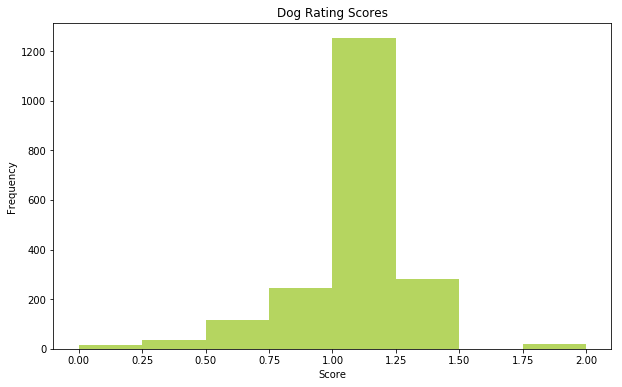

In [53]:
tweets_clean['rating'] = tweets_clean.rating_numerator/tweets_clean.rating_denominator
tweets_clean.rating.plot(kind='hist', bins=8, figsize=(10,6),
                         color='#A3CB38', alpha=0.8);
plt.title('Dog Rating Scores')
plt.xlabel('Score');
print('mean:', tweets_clean.rating.mean())
print('median:', tweets_clean.rating.median())
print('std:', tweets_clean.rating.std())

<b>Analysis:</b> The above histogram summaries dog rating scores. The following were observed:
- There seems to be some outlier scores between 1.75 and 2.00. This is most likely to the nature of the rating system. Meaning there's no limit how good dogs can be, so I decided to include those score. 
- The distribution is left skewed. Therefore, mean is lower than the median. The distribution has a high kurtosis with a standard deviation of 0.23 around the mean of 1.06. Therefore, most of the dogs are very good dogs.

Favourite
mean: 8540.558044806518
std: 12546.566436239129

Retweet
mean: 2550.2780040733196
std: 4557.693506024708


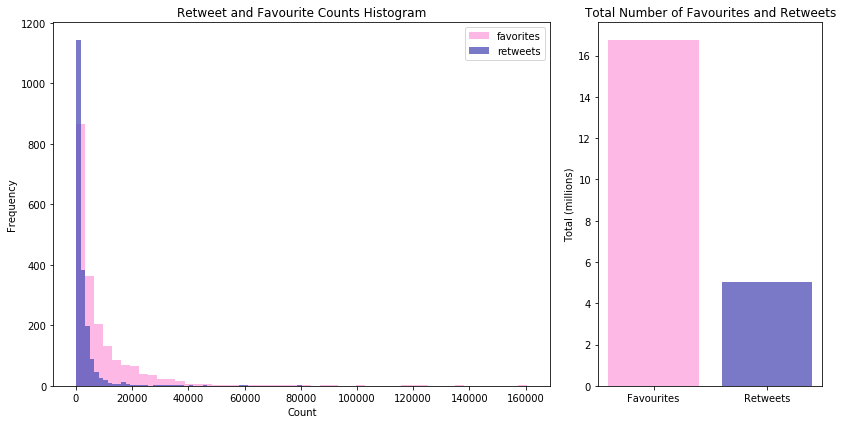

In [54]:
import matplotlib.gridspec as gridspec

# figure with subplots
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(1,3)

# small subplot
plt.subplot2grid((1,3), (0,2))
plt.bar([0, 1], [tweets_clean.favorites.sum()/1000000,
                 tweets_clean.retweets.sum()/1000000],
        tick_label = ['Favourites', 'Retweets'],
        color = ['#FDA7DF', '#5758BB'], alpha=0.8);
plt.title('Total Number of Favourites and Retweets')
plt.ylabel('Total (millions)');

# largle subplot
plt.subplot2grid((1,3), (0,0), colspan=2, rowspan=1)
tweets_clean.favorites.plot(kind='hist', bins= 50, figsize=(12,6),
                                  alpha=0.8, color='#FDA7DF');
tweets_clean.retweets.plot(kind='hist', bins= 50, figsize=(12,6),
                                  alpha=0.8, color='#5758BB');
plt.legend();
plt.title('Retweet and Favourite Counts Histogram');
plt.xlabel('Count');
print('Favourite')
print('mean:', tweets_clean.favorites.mean())
print('std:', tweets_clean.favorites.std())
print('')
print('Retweet')
print('mean:', tweets_clean.retweets.mean())
print('std:', tweets_clean.retweets.std())

fig.tight_layout()

<b>Analysis</b>: The graph on the left are histograms for how many times the tweets are favourited or retweeted. Both distributions are right skewed. Meaning, mean is higher than the median. For favorited tweets, the mean is 8862 with a standard deviation of 11471.83. For retweeted tweets, the mean is 2491.61 with a standard deviation of 3737.75. This means, a tweet on average gets favorited more times than retweeted. The total favourites and retweets can be seen on the bar char on the right. Tweets get much more favorites.

In [55]:
#calculate rating ration
tweets_clean['rating_ratio'] = tweets_clean['rating_numerator']/tweets_clean['rating_denominator']

C:\Users\h275621\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


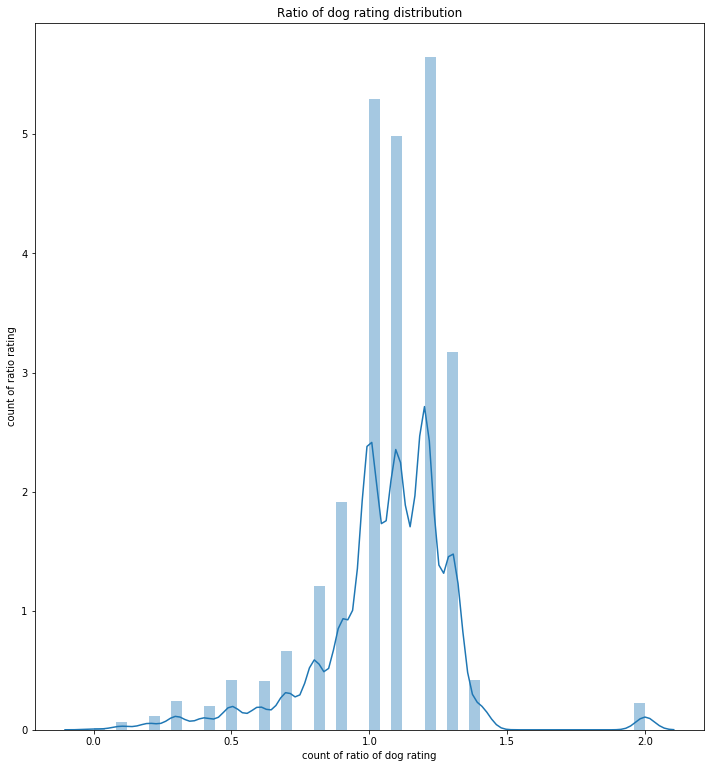

In [56]:
plt.rcParams['figure.figsize']=(12,13)
sns.distplot(tweets_clean.rating_ratio).set_title('Ratio of dog rating distribution');
plt.xlabel('count of ratio of dog rating')
plt.ylabel('count of ratio rating')
plt.show();

<b>Analysis</b>: Here after we calculated the ratio of dog rating from(rating numerator /rating denominator)rate, we can see that the chart takes normally distribution of dogs rating.

In [57]:
tweets_clean.drop(tweets_clean.query('(name == "None")').index ,inplace=True)

In [58]:
tweets_clean.drop(tweets_clean[tweets_clean.name.isnull()].index, inplace=True)

In [59]:
err_tweets_clean = tweets_clean.name.str.contains('^[a-z]', regex = True)
tweets_clean[err_tweets_clean].name.value_counts().sort_index()

a               55
actually         1
all              1
an               6
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             3
light            1
my               1
not              1
officially       1
one              4
quite            3
space            1
such             1
the              7
this             1
unacceptable     1
very             4
Name: name, dtype: int64

In [60]:
tweets_clean.drop(tweets_clean[err_tweets_clean].index, inplace=True)

In [61]:
tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1342 entries, 0 to 1933
Data columns (total 12 columns):
tweet_id              1342 non-null object
timestamp             1342 non-null datetime64[ns, UTC]
source                1342 non-null object
text                  1342 non-null object
rating_numerator      1342 non-null int64
rating_denominator    1342 non-null int64
name                  1342 non-null object
dog_rank              176 non-null object
favorites             1342 non-null object
retweets              1342 non-null object
rating                1342 non-null float64
rating_ratio          1342 non-null float64
dtypes: datetime64[ns, UTC](1), float64(2), int64(2), object(7)
memory usage: 136.3+ KB


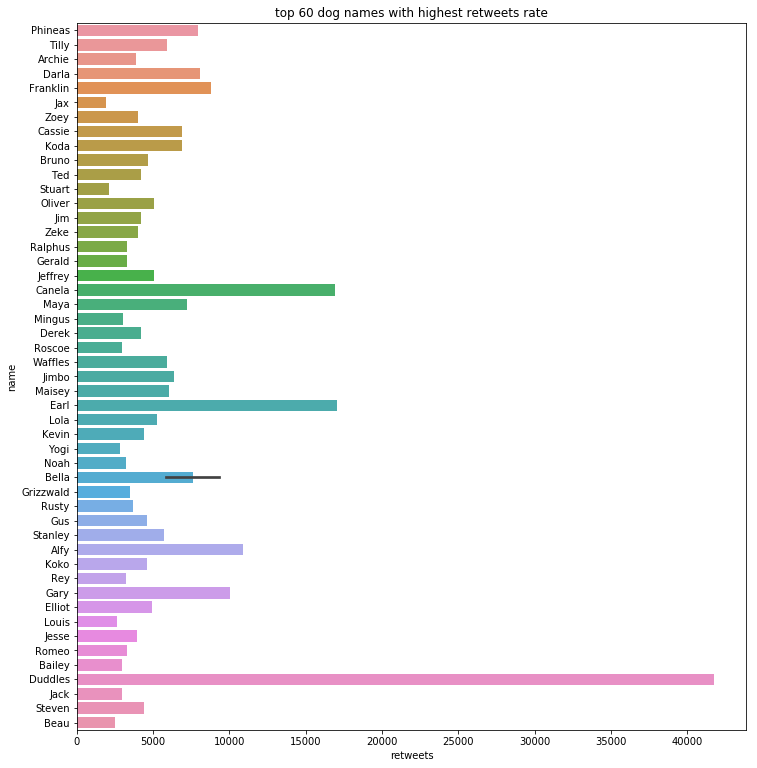

In [62]:
sns.barplot(y="name", x="retweets", data = tweets_clean[0:50]).set_title('top 60 dog names with highest retweets rate');

<b>Analysis</b>: After removing None values, and removed inappropriate dog names such as ("a", "an", "the", "very", "quite",... we, want to find out the top 50 of dog names which are recorded the highest retweets rating.

As we can see from the chart the name of dog "Duddles" recorded the highest rate of retweets, then the name of dog "Canela"and "Earl" are having almostsame retweets, and so on.